__Name:__ Joaquin Quintana

__Date:__ May 2, 2022

Linear Algebra Final - Portfolio Optimization

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pyt 

In this notebook we look at portfolio optimization using a linear algebra approach. I start by going through an example in chapter 17 of the VMLS textbook [1] and then use these techniques on my own data set to further explain portfolio optimization. The data for the example problem was acquired from Jessica Wyleung whom is the the author of the pyhton companion note book and was kind enough to place the data set on her github for others to use: https://github.com/jessica-wyleung/VMLS-py. Credit for Algortihms port_opt, back_subst, QR Factorization, solve_via_backsub and gram_schmidt goes to the authors of the Python Companion Notebook [2]. 

The first part of this notebook will look at portfolio optimization starting with the assests. The math and algorithms used for portfolio optimization are described first, followed by book problem 17.1.3 which show how to use these algorithms for portfolio optimization. Finally, we look at a dataset I acquired using yfinnace and show how to use the algortihms walked through here along with how to compute the same result using numpy's constrained linear least square function. The code for acquring the data can be found in the file GetTickers.py.  

__Note:__ Past returns from a set of n assets over time, T, which is in some unit like days or weeks will be used here. These assets can be of any kind but here they are stocks. A large assumption made here is that future asset returns are similar to past returns, which over time tends to be true but is not guranteed. Or better stated by
Peter Lynch [3]:
    
* __Basic corporate profits have grown about 8% a year historically. So, corporate profits double about every nine years. The stock market ought to double about every nine years.__

## Part 1: Details of portfolio optimization

We will start by describing a 2000*20 matrix, $R$, which contains 19 assests in the columns and a risk free assent in the 20th column. The risk free assset here is cash with a 1% annualized return. 

The problem uses a fixed return given by $\rho$ and we want to minimize the risk over all portfolios and still achieve the return $\rho$. 

The portfolio return can be expressed as: 
$$avg(r) = \frac{1}{T}1^T(Rw) = \mu^Tw = \rho$$

Here $\mu = \frac{R^T1}{T}$ and is an $n$-vector of average asset returns.

Now if the above holds we can express the square of the risk as $$std(r)^2 = (\frac{1}{T})||r-avg(r)1||^2 = (\frac{1}{T})||r-\rho 1||^2$$. 

Therefore to minimize the risk squared, given we want a return $\rho$, we need to solve the following constrained least sqaures problem.

__minimize__ $$||Rw-\rho 1||^2$$

__subject to__ $$ \begin{bmatrix} 1^T \\ \mu^T  \end{bmatrix} w = \begin{bmatrix} 1 \\ \rho  \end{bmatrix}$$


This is a constrained least squares problem with two linear equality constraints which are:

1. Set sum of allocation weights, $w = 1$
2. Requires mean portfolio return $\rho$

Finally -  the portfolio optimization problem has the solution...

$ \begin{bmatrix} w \\ z_1 \\ z_2 \end{bmatrix} = \begin{bmatrix} 2R^TR && 1 && \mu \\ 1^T && 0 && 0 \\ \mu^T && 0 && 0 \end{bmatrix}$

__Note:__ we need not care about $z_1$ and $z_2$ but do care about $w$. In python we can define this solution as ...

We will use back substitution to solve the set of linearly constrained equations described above. This can be achievied using QR Factorization and the Gram Schmidt's algorithm. 

Back substiution is an algorithm that can be used to solve $Rx = b$ or a set of linear equations. Here $R$ is a upper triangular $n*n$ matrix and has a non zero diagonal while $x$ & $b$ are $n$-vectors. Such a set of linear equations has the expanded form ...

$$R_{11}x_1 + R_{12}x_2, ... , R_{1,n-1}x_{n-1} = b_1$$

$$\vdots$$  

$$R_{n-2,n-2}x_{n-2} + R_{n-2,n-1}x_{n-1} + R_{n-2,n}x_n = b_{n-2}$$

$$R_{n-1,n-1}x_{n-1} + R_{n-1,n}x_n = b_{n-1}$$

$$R_{n,n}x_n = b_{n}$$

__The last equation can be wrtten as:__  $x_n = \frac{b_n}{R_{nn}}$

From this last equations we see by simply rearrangment that we can solve for $x_n$. This value can then be back substituted into the equation which was just before it. By repeating this last step we can solve the set of linear equations. This is, we seek the n-vector $x$ and via back subtitution we get $x = R^{-1}b$. $x = R^{-1}b$ is the product of the inverse of matrix R and b which returns the n-vector $x$. Note that we need not worry about division by zero since the matrix $R$ has a non zero diagonal for which the division in each step is with one of the entries of the diagonal. Python code for the back_subst given a upper right triangular matrix R and an $n$-vector $b$ is shown in the next cell. 

In [2]:
def back_subst(R,b_tilde):
    #get the shape and preallocate a n-vector of zeros for storing the result of the back sub
    n = R.shape[0]
    x = np.zeros(n)
    #Start with the last element as we are back substituting. Substitue the result in the second to last equation and repeat until all elements in x are computed. 
    for i in reversed(range(n)):
        x[i] = b_tilde[i]
        for j in range(i+1,n):
            x[i] = x[i] - R[i,j]*x[j]
        x[i] = x[i]/R[i,i]
    return x

To obtain the upper triangular matrix of $R$ we can compute the the QR factorization for a matrix $A$. The QR factorization returns matricies $Q$ and $R$ and $Q$ and $R$ are the factored matricies of $R$. This is, $A = QR$. For example using a random matrix.  

In [3]:
A = np.random.rand(2000,20)
A.shape

(2000, 20)

In [4]:
def QR_factorization(A):
    #run gram schmidt on columns to get Q and othonormalized set of vecotrs
    Q_transpose = np.array(gram_schmidt(A.T))
    #comput the upper trigular matrix R
    R = Q_transpose @ A
    Q = Q_transpose.T
    return Q, R

def gram_schmidt(a):
    q = []
    for i in range(len(a)):
    #orthogonalization
        q_tilde = a[i]
        for j in range(len(q)):
            q_tilde = q_tilde - (q[j] @ a[i])*q[j]
        #Test for dependennce
        if np.sqrt(sum(q_tilde**2)) <= 1e-16:
            print('Vectors are linearly dependent.')
            print('GS algorithm terminates at iteration ', i+1)
            return q
            #Normalization
        else:
            q_tilde = q_tilde / np.sqrt(sum(q_tilde**2))
            q.append(q_tilde)
    #print('Vectors are linearly independent.')
    return q

In [5]:
#compute the QR factorization of random matrix A
Q,R = QR_factorization(A)
#compute the product of Q and R
A_2 = Q@R
#show that Q and R are simply the factored form of matrix A. 
print(np.round(A,6)==np.round(A_2,6))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


Next notice the use of the __Gram Schmidt algorithm__ in the QR factorization function. The Gram Schmidt algorithm takes in a set of $n$-vectors, $a = a_1, ..., a_k$, and if the set is linearlly independent returns a set of orthonormalized vectors from the input. 

Here is pseudocode and the algorithm in python is defined above. 

Given a set of $n$-vectors $a = a_1, ..., a_k$

__For $i$ in len(a):__
   * __Orthogonalization ($Q$): $\hat q = a_i - (q_1^Ta_i)q_1 - ... - (q_{i-1}a_i)q_{i-1}$__
    
    
   * __Test for dependence (early termination):__ if $\hat q = 0$, quit
   
   
   * __Normalization:__ $q_i = \frac{\hat q_i}{||\hat q_i||}$
   
   Where $||\hat q_i||$ is the norm of $\hat q_i$.

Notice in the second step we test for dependence. If the set of vectors is not linerally independent the algorithm terminates early and it returns the set of linearlly independent vectors up to the vector $a_j$ which the algorithm terminated at. The last term is not part of linerally independent set of vectors but can be used to write the set $a_1,...,a_{j-1}$ as a linear combination of $a_j$. The set of vectors, $a$, as a whole would be considered linerally dependent if the early termination is triggered. For the portfolio optimization here we need not worry about this. 

The reason we need not worry is we are typically looking at a timeseries T which is over many periods. For example, in the problem here we have a portfolio with $T = 2000$ days (aka periods) and $n = 20$ assets. We represent this information as a matrix $A$ which has size $T*n$ and our assests are therefore the columns of the matrix. Finally, by the independence dimension inequality we know that for a set of $n$-vectors, $a = a_1,...,a_k$, to be linerally independent they must have $n\leq k$. In the matrix $A$ we have $n = 20$ and $k = 2000$ and therefore by the independence dimension inequality the columns of matrix $A$ are lineraly independent. This will be the case for the portfolios we look at here as we always have more periods than assests as we are using historical data for acquiring ideal weights, $w$, for optimizing portfolios. Addiontally, there are no zero vector columns or rows in matrix $A$. This last statment comes with the caveat that a assest which does not fluctuate much from day to day can have a really small return. This is, a return can be as low as 10^-20 which is practically zero and from this point of view it is clear that this becomes a question of where the cut off for zero should be given we desire to optimize portfoilios.  

Finally - the port_opt function takes in our portfolio as matrix of size $T*n$ and the desired return, $\rho$. Inside the function the solution to the constrained least squares problem is constructed as a set of linear equations in matrix KKT. We the use solve_via_backsub to solve the set of linearly constrained equations with the desired return vector b. 

Notice that we use QR factorization here to obtain the desired solution b and the upper triangular matrix $R$. $R$ and $b$ are then used for back substitution (described above) which computes the n-vector $x$ in the set of linear equations described by the function $Rx = b$. 

__Note:__ port_opt is the main function for optimizing a portfolio R given some return rho. 

In [6]:
def solve_via_backsub(A,b):
    #factorize the matrix a into matricies Q and R
    Q,R = QR_factorization(A)
    #Get b for the computation Rx = b
    b_tilde = Q.T @ b
    #R is upper trigular and can be used for back substitution 
    x = back_subst(R,b_tilde)
    return x

In [7]:
def port_opt(R, rho):
    #information to setup solution for portfolio optimization 
    T, n = R.shape
    mu = np.sum(R, axis = 0).T/T
    
    #Solution to portfolio optimization 
    KKT = np.vstack([np.column_stack([2*R.T @ R, np.ones(n), mu]),
    np.hstack([np.ones(n).T, 0 , 0]), np.hstack([mu.T, 0,0])])
    
    #Solve solution using back substitution 
    wz1z2 = solve_via_backsub(KKT, np.hstack([2*rho*T*mu, 1,rho]))
    #return the weights w from the solution. We need not care about z1 or z2 
    w = wz1z2[:n]
    return w

Now that the idea behind portfolio optimization is laid out lets put into practice. 

# Part2 - Demonstrate VMLS problem 17.1.3 [1]

Below we load the data that is used for example 17.1.3 in VMLS. This data was aquired from Jessica Wyleung whom is the the author of the pyhton companion note book and was kind enough to place the data set on her github for others to use [2]. 

Github: https://github.com/jessica-wyleung/VMLS-py.

In the next cell we compute the daily returns for all the assets in the portfolio. Then the data is split into training and testing sets of size 2000 and 500, respectively (here the period is trading days). The training set is a set of returns from an earlier time interval and the testing set are the returns at a later time interval (the two sets are disjoint). We will use the testing set to find weights, $w$, which we will use to model portfolio returns given the risk for each asset and the desired return. We can test these discovered weights, $w$, by running the portfolio optimization on the testing dataset with the weights found while optimizing the training data. 

__Note:__ to simplify things an initial investment of 10,000 US dollars is used for all portfolios analyzed here.  

In [8]:
prices =  pd.read_csv('PortfolioDataVMLS.csv',delimiter= '\t') 
prices.columns = ["American Express Company","Bank of America Corporation","BP plc", "Broadcom Corp.","Costco Wholesale Corporation", "Cisco Systems, Inc.", "The Walt Disney Company", "The Goldman Sachs Group, Inc.","Hewlett-Packard Company", "Intel Corporation", "The Coca-Cola Company", "3M Company", "Microsoft Corporation", "Nike, Inc.", "QUALCOMM Incorporated", "Starbucks Corporation", "AT&T, Inc.", "Tiffany & Co.", "Verizon Communications Inc.", "US Dollar"]

#computing the difference matrix for each assest
p_diff =np.diff(prices,axis = 0)

#compute stock changes from the last time period to the next for each period . This is the daily returns 
returns = p_diff / prices.iloc[:-1,:];

#break data into train and test set
R = returns.iloc[:2000,:]; 
rtest = returns.iloc[2000:2500,:];

#display the head of the train set 
R.head()

,American Express Company,Bank of America Corporation,BP plc,Broadcom Corp.,Costco Wholesale Corporation,"Cisco Systems, Inc.",The Walt Disney Company,"The Goldman Sachs Group, Inc.",Hewlett-Packard Company,Intel Corporation,The Coca-Cola Company,3M Company,Microsoft Corporation,"Nike, Inc.",QUALCOMM Incorporated,Starbucks Corporation,"AT&T, Inc.",Tiffany & Co.,Verizon Communications Inc.,US Dollar
0,0.001662,-0.001656,0.006268,-0.011082,0.011318,0.011414,0.002404,-0.005875,0.004392,-0.000400,-0.004262,-0.003053,0.003398,-0.001349,-0.009746,0.012125,0.002587,0.008137,0.016563,0.00004
1,0.003042,-0.002322,-0.023669,0.000896,0.014483,0.019965,0.016787,0.020973,-0.017493,0.033253,-0.006421,-0.017152,-0.000968,0.003376,0.028241,-0.003783,0.010323,-0.013721,0.002037,0.00004
2,-0.003033,0.000332,0.000957,0.019704,0.004543,0.030638,0.014623,0.001248,0.056874,0.007367,0.004847,-0.006700,-0.001453,0.010094,0.057428,-0.008861,0.018519,-0.024550,0.015244,0.00004
3,-0.007467,-0.008641,0.000319,0.019763,0.019057,0.005367,-0.003719,-0.012696,-0.021058,-0.008083,-0.010718,-0.003451,-0.017944,-0.007328,0.000000,-0.008301,-0.050784,-0.001119,-0.029029,0.00004
4,-0.003901,0.001676,0.011787,0.114987,-0.006973,0.020945,0.000467,0.002870,0.021511,0.005433,0.008667,0.009287,-0.003457,0.014094,0.019284,0.007727,0.024439,-0.025756,0.019072,0.00004


In [9]:
# we will be computing the weights and returns a lot so we define this here. 
def GetWeightandReturn(R,rho):
    w = port_opt(R, rho)
    r = R @ w #Portfolio return time series
    return w,r

Optimize four portfolios with deisired returns, $\rho$: 10%, 20%, 40%, 1/n (uniform portfolio). This is our training data and we will obtain $w$ from this set to use on our testing data. 

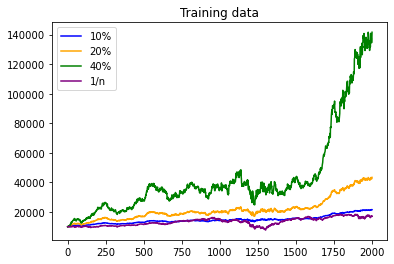

In [10]:
#get the shape of 
T, n = R.shape

#define fine function to get
cum_value = lambda r: 10000*np.cumprod(1+r)

#compute weight and return given we desire rho % annual return
w1,r1 = GetWeightandReturn(R,0.1/250)#Ask for 10% annual return
w2,r2 = GetWeightandReturn(R,0.2/250)#20% annual return
w3,r3 = GetWeightandReturn(R,0.4/250)#40% annual return
# Uniform portolio
w4 = (1/n)*np.ones(n)
r4 = R @ w4 
#store this info so we can place it in a chart later
rTraining = [r1,r2,r3,r4]
#plot our results
for r,c in zip(rTraining,['blue','orange','green','purple']):
    plt.plot(np.arange(T), cum_value(r), c)
plt.title("Training data")
plt.legend(['10%','20%','40%','1/n'])
plt.show()

# Now we use $w$ found from training set! 

Using the weight we found from the training data we can now see how well the model works for our testing data.

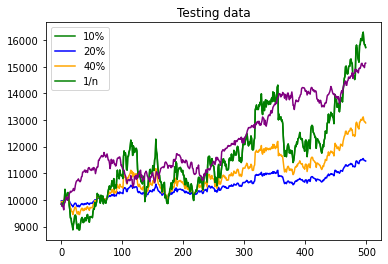

In [11]:
T, n = rtest.shape

cum_value = lambda r: 10000*np.cumprod(1+r)

# 10% annual return

#Ask for 10% annual return
r1 = rtest @ w1 #Portfolio return time series

# 20% annual return
r2 = rtest @ w2 #Portfolio return time series

# 40% annual return
r3 = rtest @ w3 #Portfolio return time series
plt.plot(np.arange(T), cum_value(r3), 'green')

# Uniform portolio
#w = (1/n)*np.ones(n)
r4 = rtest @ w4 #Portfolio return time series

rTesting = [r1,r2,r3,r4]

for r,c in zip(rTesting,['blue','orange','green','purple']):
    plt.plot(np.arange(T), cum_value(r), c)
plt.title("Testing data")
plt.legend(['10%','20%','40%','1/n'])
plt.show()


Next - let's take  closer look at the results for 4 of the 5 portfolios shown in example 17.1.3 of VMLS. Here we will show the risk and return for the trianing and testing datasets. 

In [12]:
def AnnualRiskandReturn(r):
    #define fine function to get with intial input of 10,000
    cum_value = lambda r: 10000*np.cumprod(1+r)
    pf_return = 250*sum(r)/len(r)
    pf_risk = np.sqrt(250)*np.std(r)
    return pf_return,pf_risk

In [13]:
#Get the return and risk from the portfolios and plot them 
trainingReturnRisk  = [AnnualRiskandReturn(i) for i in rTraining]
testsReturnRisk  = [AnnualRiskandReturn(i) for i in rTesting]

trainResult = pd.DataFrame(np.around(trainingReturnRisk,2))
testResult = pd.DataFrame(np.around(testsReturnRisk,2))

#organize data into train and test with return and risk for each set of data
dd = pd.concat([trainResult,testResult],axis = 1)
dd.columns = pd.RangeIndex(dd.columns.size)
header = [np.array(['Train','Train','Test','Test']), np.array(['Return','Risk','Return','Risk'])] 
df = pd.DataFrame(dd.to_numpy(), columns = header )   
df

Train         Test      
  Return  Risk Return  Risk
0   0.10  0.09   0.07  0.07
1   0.20  0.18   0.14  0.15
2   0.40  0.37   0.27  0.31
3   0.09  0.23   0.22  0.13

Plot the pareto optimized portfolios along with each assest on its own. Plot this data on a risk and return plot. 

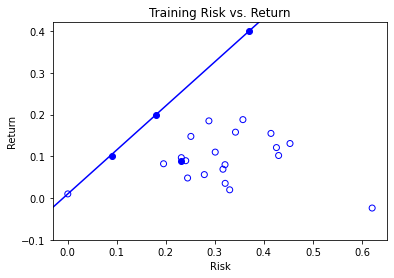

In [14]:
I = np.identity(n)
risk_return = [AnnualRiskandReturn(R@I[i]) for i in range(n)]
#unpack list of tuples
y, x = zip(*risk_return)

plt.scatter(x, y,facecolors='none', edgecolors='b')
plt.scatter(trainResult[1],trainResult[0],color = 'b')

#create line that show the pareto portfolios at 10%, 20%, 40$ risk
p1 = x[-1],y[-1] #risk free assets
p2 = (trainResult[1][1],trainResult[0][1]) #
plt.axline(p1, p2, color='b');

plt.ylim(bottom=-0.1)
plt.title("Training Risk vs. Return")
plt.xlabel('Risk');plt.ylabel('Return');

Next - lets look at the $w$ and see how the intial investment was allocated over the 20 assests in each of the 4 portfoilos.

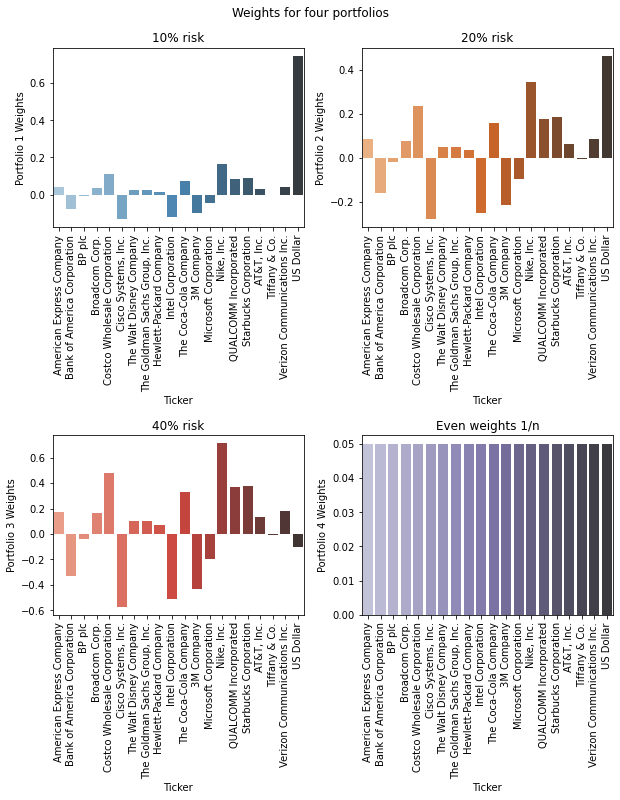

In [15]:
l = R.columns
# Create DataFrame
weights1 = pd.DataFrame({'Ticker':l,
        'Portfolio 1 Weights':w1})
weights2 = pd.DataFrame({'Ticker':l,
        'Portfolio 2 Weights':w2})
weights3 = pd.DataFrame({'Ticker':l,
        'Portfolio 3 Weights':w3})
weights4 = pd.DataFrame({'Ticker':l,
        'Portfolio 4 Weights':w4})

fig, axes = plt.subplots(2, 2, figsize=(8.5, 11),constrained_layout = True)

fig.suptitle('Weights for four portfolios')

ul = sns.barplot(ax=axes[0, 0],x="Ticker", y="Portfolio 1 Weights", data=weights1, palette="Blues_d")
ur = sns.barplot(ax=axes[0, 1],x="Ticker", y="Portfolio 2 Weights", data=weights2, palette="Oranges_d")
ll = sns.barplot(ax=axes[1, 0],x="Ticker", y="Portfolio 3 Weights", data=weights3, palette="Reds_d")
lr = sns.barplot(ax=axes[1, 1],x="Ticker", y="Portfolio 4 Weights", data=weights4, palette="Purples_d")
#set tickers so people know which stock the weight is for 
ul.tick_params(axis='x', rotation=90)
ur.tick_params(axis='x', rotation=90)
ll.tick_params(axis='x', rotation=90)
lr.tick_params(axis='x', rotation=90)
#place titles 
ul.set_title("10% risk");
ur.set_title("20% risk");
ll.set_title("40% risk");
lr.set_title("Even weights 1/n");

We see that the weights of our portfolio can be negative. A negative weight implies we borrow money from asset $i$ and place it into asset $j$ and is known as shorting. 

# Now that we have everything working lets put this model into practice using my own data set.

In [16]:
#Cummulative value 
def ToColumnForm(DataFrame,ticker):
    #use the adjusted close from each company
    DataFrame = DataFrame[['Adj Close', 'ticker']]
    DataFrame = DataFrame[DataFrame['ticker'].str.contains(ticker)]
    return DataFrame.rename(columns={"Adj Close": ticker}).drop(['ticker'],axis=1)


def GetAnnualCompound(intialInvetment,annualizedReturn, risk, numberOftradingPeriods):
        cum_value = lambda r: intialInvetment*np.cumprod(1+r)
        T = 250 # One year's worth of trading days
        #Generate random returns sequence with
        #10% annualized return, 5% annualized risk
        mu = (annualizedReturn)/T
        #we consider a risk free assest to have sigma = 0.0
        sigma = risk/np.sqrt(T)
        r = mu + sigma*np.random.normal(size = numberOftradingPeriods)
        v = cum_value(r)
        #print(v)
        # compute final value (compounded) and average return
        v[numberOftradingPeriods-1], v[0]*(1+sum(r))
        return v

In [17]:
df = pd.read_pickle('portfolio.pkl')
df.head()

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2012-04-02,21.493929,22.098928,21.442142,22.093929,18.918457,598351600.0,AAPL
2012-04-03,22.403570,22.578930,22.232500,22.475714,19.245380,834559600.0,AAPL
2012-04-04,22.298214,22.352142,22.035713,22.296785,19.092159,572980800.0,AAPL
2012-04-05,22.392143,22.666430,22.264286,22.631430,19.378706,641298000.0,AAPL
2012-04-09,22.361786,22.851429,22.332144,22.722500,19.456690,597536800.0,AAPL


Check all the tickers in the dataset have the same number of trading days. 

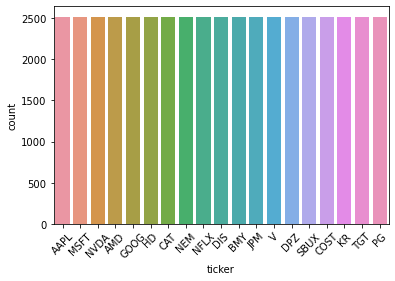

In [18]:
#ax = sns.set(rc={'figure.figsize':(8.5,11)})
sns.countplot(x="ticker",data=df);
pyt.xticks(rotation=45);

Organize the data so we have the $n$ assets in the columns with the $T$ periods.

In [19]:
#get a list of unique tickers in this data set
listTickers = df['ticker'].unique()
#convert the dataset into a list of AataFrames with dates and adjusted close 
DataColumnsWithTicker = [ToColumnForm(df,tick).reset_index() for tick in listTickers]

#get all data into a matrix we can use 
from functools import reduce
#we will merge all DataFrames using the dates to match row wise. 
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='outer'), DataColumnsWithTicker)
df2 = df_merged.drop_duplicates(subset=['Date']).reset_index(drop = True)
#show the data in column form that we will work with. 
df2.head()

,Date,AAPL,MSFT,NVDA,AMD,GOOG,HD,CAT,NEM,NFLX,DIS,BMY,JPM,V,DPZ,SBUX,COST,KR,TGT,PG
0,2012-04-02,18.918457,26.253548,3.519975,8.20,322.252106,40.099873,80.578499,42.587700,16.281429,39.251865,24.991209,34.796448,3.519975,33.597618,23.937647,70.189789,10.200632,44.210564,49.804794
1,2012-04-03,19.245380,25.968983,3.462572,7.98,320.110138,40.107891,79.797150,41.141151,16.137142,38.759426,25.229568,34.485157,3.462572,33.606701,24.039030,69.081573,9.924601,43.899593,49.458321
2,2012-04-04,19.092159,25.375446,3.363837,7.81,316.389099,39.987576,79.834709,39.661892,15.751429,38.437103,25.102942,33.718319,3.363837,32.916214,24.060150,68.049828,9.845139,43.854065,49.583633
3,2012-04-05,19.378706,25.627499,3.359246,7.87,314.979370,40.605236,79.541702,39.008076,15.785714,38.571407,25.088036,33.665161,3.359246,33.007065,24.575481,67.751793,9.970608,43.778244,49.620506
4,2012-04-09,19.456690,25.286009,3.315618,7.75,314.242157,40.573135,77.813660,39.228741,15.240000,37.702927,24.611309,33.323505,3.315618,32.171204,24.254457,67.163300,9.828408,43.626549,49.251896


Notice we need a risk free asset. In the VMLS text book the risk free asset was cash however in practice US bonds are often used as they are stable. I will use the average annual return in [2018 for 10-year](https://www.statista.com/statistics/189341/annual-percent-change-in-return-on-10-year-bonds-in-the-us-since-1990/#:~:text=The%20statistic%20presents%20the%20average,U.S.%20amounted%20to%200.34%20percent) bonds in the U.S. which was 3.4 %. Here is an example showing how to compute a risk free asset using 1.00 US Dollar with a 1.0% annual return. After this we will show that we can do this with bonds but with an intial investment of 10,000 US Dollar and 3.4% annual return. The risk free asset used moving forward will be the US bonds with 3.4% annual return. 



In [20]:
#Us Dollar at 1.00 %
intialInvetment = 1.00
annualizedReturn = 1/100
risk = 0.00
numberOftradingPeriods = 2516
USDollarReturn = GetAnnualCompound(intialInvetment, annualizedReturn, risk, numberOftradingPeriods)

Load the data from VMLS example and show we have computed the same result for the risk free assest used there. We will use this aglorithm to compute the annual return over our time period $T$ for US bonds next. Plot the data we just computed and the data in the example for the VMLS example. The two lines should overlap as we have computed the same risk free asset, i.e., 1.00 dollar with 1.0% return over period $T$. 

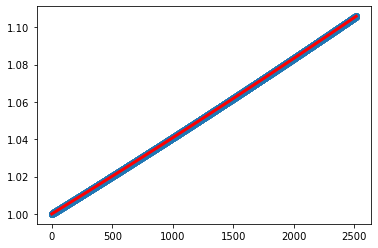

In [21]:
prices =  pd.read_csv('PortfolioDataVMLS.csv',delimiter= '\t') 
prices.columns = ["American Express Company","Bank of America Corporation","BP plc", "Broadcom Corp.","Costco Wholesale Corporation", "Cisco Systems, Inc.", "The Walt Disney Company", "The Goldman Sachs Group, Inc.","Hewlett-Packard Company", "Intel Corporation", "The Coca-Cola Company", "3M Company", "Microsoft Corporation", "Nike, Inc.", "QUALCOMM Incorporated", "Starbucks Corporation", "AT&T, Inc.", "Tiffany & Co.", "Verizon Communications Inc.", "US Dollar"]
plt.plot(range(2516),USDollarReturn,color = 'r', linewidth = 3);
plt.scatter(range(2516),np.array(prices["US Dollar"]));

Now lets compute a risk free asset using US bonds with a 3.4 % annualized return and append it as the last column to the portfolio shown above. We no longer need the date column either so we will drop that here. 

In [22]:
#US Treasury bonds
intialInvetment = 10000
annualizedReturn = 3.4/100 #3.4 %
risk = 0.00 #0% risk lets be optimistic
numberOfDays = len(df2)#This is the number of days T
#compute the annual compunded value over the time period T.  
USBonds = GetAnnualCompound(intialInvetment, annualizedReturn, risk, numberOfDays)
#append column to our dataFrame
df2['USBonds'] = USBonds
#drop date column
portfolio = df2.drop(['Date','DPZ'], axis = 1)
#show the world some results
portfolio.head()

,AAPL,MSFT,NVDA,AMD,GOOG,HD,CAT,NEM,NFLX,DIS,BMY,JPM,V,SBUX,COST,KR,TGT,PG,USBonds
0,18.918457,26.253548,3.519975,8.20,322.252106,40.099873,80.578499,42.587700,16.281429,39.251865,24.991209,34.796448,3.519975,23.937647,70.189789,10.200632,44.210564,49.804794,10001.360000
1,19.245380,25.968983,3.462572,7.98,320.110138,40.107891,79.797150,41.141151,16.137142,38.759426,25.229568,34.485157,3.462572,24.039030,69.081573,9.924601,43.899593,49.458321,10002.720185
2,19.092159,25.375446,3.363837,7.81,316.389099,39.987576,79.834709,39.661892,15.751429,38.437103,25.102942,33.718319,3.363837,24.060150,68.049828,9.845139,43.854065,49.583633,10004.080555
3,19.378706,25.627499,3.359246,7.87,314.979370,40.605236,79.541702,39.008076,15.785714,38.571407,25.088036,33.665161,3.359246,24.575481,67.751793,9.970608,43.778244,49.620506,10005.441110
4,19.456690,25.286009,3.315618,7.75,314.242157,40.573135,77.813660,39.228741,15.240000,37.702927,24.611309,33.323505,3.315618,24.254457,67.163300,9.828408,43.626549,49.251896,10006.801850


Compute the daily returns by using the differnce matrix of the portfolio. 

In [23]:
#computing the difference matrix for the assests
p_diff =np.diff(portfolio,axis = 0)

#divide the difference matrix by the data except the last row should be dropped. 
returns = p_diff / portfolio.iloc[:-1,:];
returns.tail()

,AAPL,MSFT,NVDA,AMD,GOOG,HD,CAT,NEM,NFLX,DIS,BMY,JPM,V,SBUX,COST,KR,TGT,PG,USBonds
2511,0.003734,-0.001381,-0.016270,-0.007135,0.001483,-0.016151,0.005175,0.009204,-0.004951,0.001295,0.012015,0.008743,-0.016270,0.003788,-0.004300,0.004405,0.007234,0.011583,0.000136
2512,0.005037,0.023117,0.019031,0.004763,0.003028,0.011588,-0.006760,-0.010260,0.012465,-0.003019,-0.002320,-0.007399,0.019031,0.010635,0.017095,0.000000,0.004163,0.006870,0.000136
2513,0.019134,0.015159,0.015486,0.024867,0.009158,0.010914,-0.003651,0.005247,0.035164,0.026384,0.001641,0.002201,0.015486,0.032247,0.008439,-0.010702,0.015534,0.010268,0.000136
2514,-0.006650,-0.004914,-0.033710,-0.032541,-0.004227,-0.029115,0.009229,0.017950,-0.026415,-0.009973,0.006691,-0.004533,-0.033710,-0.002192,0.011386,-0.000355,-0.004351,-0.006883,0.000136
2515,-0.017776,-0.017683,-0.014590,-0.082872,-0.020996,-0.029599,-0.001165,-0.006378,-0.018036,-0.026958,-0.002050,-0.030027,-0.014590,-0.000659,-0.001076,0.017740,-0.043882,-0.010299,0.000136


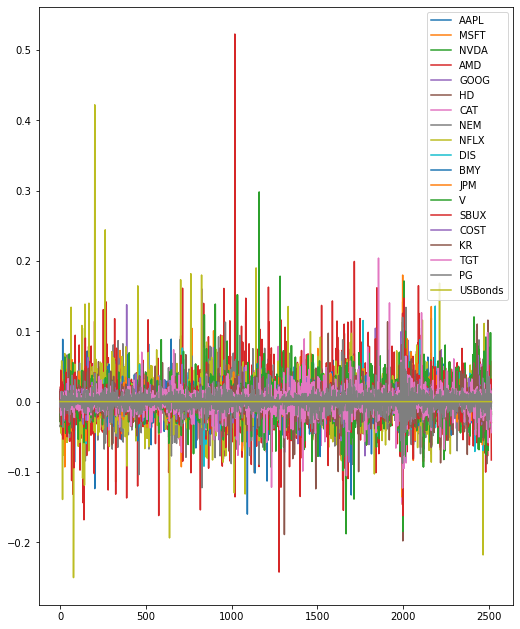

In [24]:
returns.plot(figsize=(8.5, 11));

Break the data into a train and test set. The dataset contains 10.064 years of historical data for the n assests. I will use the first 7 years of data as the training set and the last 3.064 years for testing. I'm looking to see how well the weights we find for the training set work for the testing data. The reason I have chosen the last 3 years of the data set for testing is due to its volatility. This is, during this time period the market crashed in March of 2020 (coronavirus) and has had rocky start to 2022 which this subset of data contains.

In [25]:
#break data into train and test set
R = returns.iloc[:1750,:];#7 years is  7*250(num trading days)  
rtest = returns.iloc[1750:2516,:];# 

#display the head of the test set 
R.tail()

,AAPL,MSFT,NVDA,AMD,GOOG,HD,CAT,NEM,NFLX,DIS,BMY,JPM,V,SBUX,COST,KR,TGT,PG,USBonds
1745,0.004422,0.007745,0.037534,-0.004683,0.000101,-0.008213,0.007699,-0.003186,0.013866,-0.005578,0.011711,0.003364,0.037534,0.000713,0.014681,0.010212,0.012339,0.011294,0.000136
1746,0.011117,0.000786,-0.018147,-0.023952,-0.006511,0.002595,0.001423,-0.028771,-0.006617,0.003418,-0.021189,0.009100,-0.018147,0.009130,-0.010746,0.000809,-0.008169,0.001384,0.000136
1747,0.013008,0.011519,0.025670,0.020596,-0.000919,0.003414,-0.007630,-0.008378,0.007357,0.004193,0.001403,0.011487,0.025670,-0.000990,-0.001026,-0.015758,0.002223,0.011054,0.000136
1748,0.010209,0.014321,-0.005065,-0.001718,-0.000169,0.006530,0.010779,-0.004224,0.005478,-0.016006,-0.002001,0.006007,-0.005065,0.002406,0.012800,0.007800,0.015914,-0.009078,0.000136
1749,-0.007925,0.000680,0.040012,0.118280,0.012320,0.003871,0.000373,0.008485,-0.012822,-0.027581,-0.005215,-0.003638,0.040012,0.007623,0.001944,-0.008961,0.007447,0.003842,0.000136


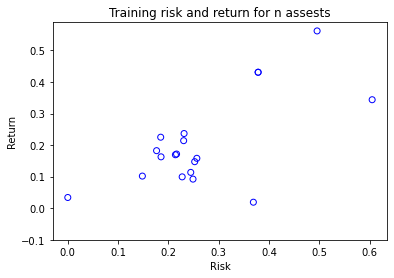

In [26]:
n,n = R.shape
I = np.identity(n)
risk_return = [AnnualRiskandReturn(R@I[i]) for i in range(n)]
#unpack list of tuples
y, x = zip(*risk_return)
#plot the risk and return as scatter
plt.scatter(x, y,facecolors='none', edgecolors='b')
plt.ylim(bottom=-0.1)
plt.xlabel('Risk');plt.ylabel('Return');
plt.title("Training risk and return for n assests");

The S&P500 has a annual return of approximatly 10%. Lets shoot for portfolio returns around 10% and not. For example, 10%, 25%, 50% and uniform which is 1/n.    

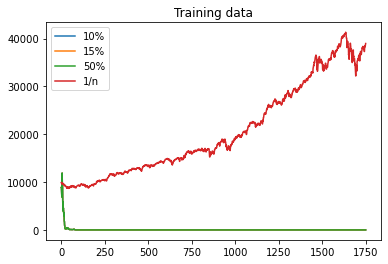

In [27]:
#get the shape of 
T, n = R.shape
cum_value = lambda r: 10000*np.cumprod(1+r)
#compute weight and return given we desire rho % annual return
w1,r1 = GetWeightandReturn(R,0.1/250)#Ask for 10% annual return
#print(r1)
w2,r2 = GetWeightandReturn(R,0.25/250)#25% annual return
#print(r2)
w3,r3 = GetWeightandReturn(R,.5/250)#50% annual return
# Uniform portolio
w4 = (1/n)*np.ones(n)
r4 = R @ w4 
rTraining = [r1,r2,r3,r4]

for ret,c in zip(rTraining,['blue','orange','green','purple']):
    plt.plot(np.arange(T), cum_value(ret))

plt.title("Training data")
plt.legend(['10%','15%','50%','1/n'])
plt.show()

Oddly the optimization for the portfolio does not look like it worked. However, with closer investigation we can see that there are few stocks which are dominating the portfolio. If we drop these stocks we get different weights for the portfolios when asking for increasing returns. Lets look at the weights from these portfolios to see what assests are dominating the portfolio. 

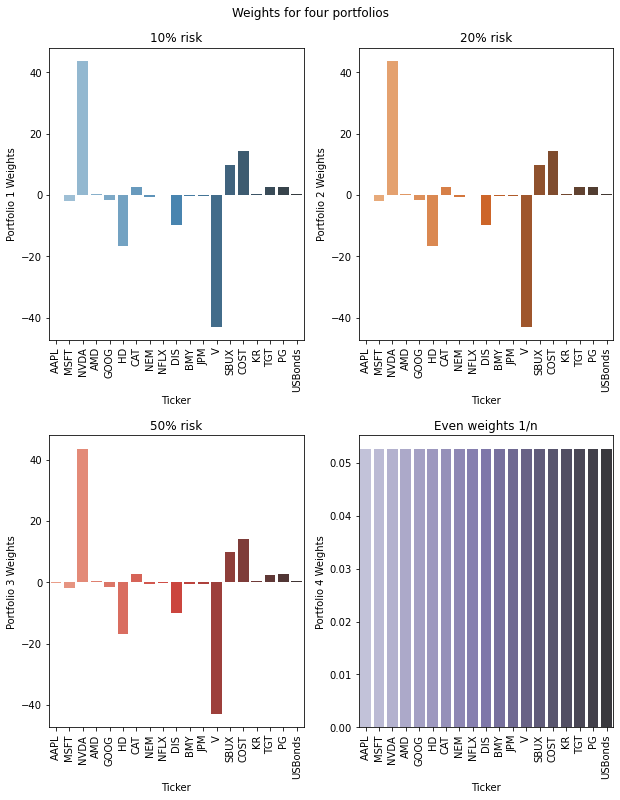

In [28]:
l = portfolio.columns
# Create DataFrame
weights1 = pd.DataFrame({'Ticker':l,
        'Portfolio 1 Weights':w1})
weights2 = pd.DataFrame({'Ticker':l,
        'Portfolio 2 Weights':w2})
weights3 = pd.DataFrame({'Ticker':l,
        'Portfolio 3 Weights':w3})
weights4 = pd.DataFrame({'Ticker':l,
        'Portfolio 4 Weights':w4})

fig, axes = plt.subplots(2, 2, figsize=(8.5, 11),constrained_layout = True)

fig.suptitle('Weights for four portfolios')

ul = sns.barplot(ax=axes[0, 0],x="Ticker", y="Portfolio 1 Weights", data=weights1, palette="Blues_d")
ur = sns.barplot(ax=axes[0, 1],x="Ticker", y="Portfolio 2 Weights", data=weights2, palette="Oranges_d")
ll = sns.barplot(ax=axes[1, 0],x="Ticker", y="Portfolio 3 Weights", data=weights3, palette="Reds_d")
lr = sns.barplot(ax=axes[1, 1],x="Ticker", y="Portfolio 4 Weights", data=weights4, palette="Purples_d")
#set tickers so people know which stock the weight is for 
ul.tick_params(axis='x', rotation=90)
ur.tick_params(axis='x', rotation=90)
ll.tick_params(axis='x', rotation=90)
lr.tick_params(axis='x', rotation=90)
#place titles 
ul.set_title("10% risk");
ur.set_title("20% risk");
ll.set_title("50% risk");
lr.set_title("Even weights 1/n");

From the charts above we see HD, V and DIS are always shorted and the weights are not being adjusted properly for the desired return. Lets drop these over dominating stocks and look at the portfolio again. This time we will see $w$ change. 

In [29]:
#drop disney, dominos and NVIDIA see if the weights change
d = returns.drop(['HD', 'DIS','V'], axis=1)
#break data into train and test set
data = d.iloc[:1750,:];#7 years is  7*250(num trading days)  
rtest_data = d.iloc[1750:-1,:];#remaining data

In [30]:
data.shape

(1750, 16)

In [31]:
rtest_data.shape

(765, 16)

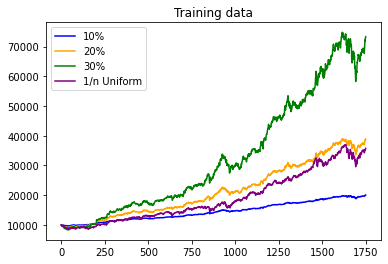

In [32]:
#get the shape of 
T, n = data.shape
#desired returns
rho = [0.1/250,0.2/250,.3/250,1/n]
cum_value = lambda r: 10000*np.cumprod(1+r)
#compute weight and return given we desire rho % annual return
w1,r1 = GetWeightandReturn(data,rho[0])#Ask for 10% annual return
#print(r1)
w2,r2 = GetWeightandReturn(data,rho[1])#20% annual return
#print(r2)
w3,r3 = GetWeightandReturn(data,rho[2])#30% annual return
# Uniform portolio
w4 = (rho[3])*np.ones(n)
r4 = data @ w4 
rTraining = [r1,r2,r3,r4]

#plot the portfolio results
for ret,c in zip(rTraining,['blue','orange','green','purple']):
    plt.plot(np.arange(T), cum_value(ret), c)
plt.title("Training data")
rho =np.array(rho)*100000 #turn row into a percent
plt.legend(['10%','20%','30%','1/n Uniform'])
plt.show()

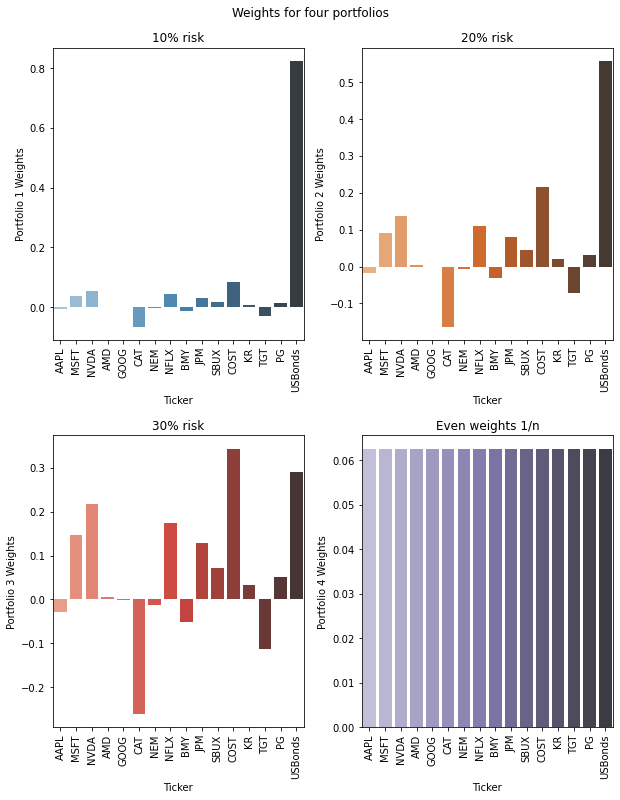

In [33]:
l = data.columns
# Create DataFrame
weights1 = pd.DataFrame({'Ticker':l,
        'Portfolio 1 Weights':w1})
weights2 = pd.DataFrame({'Ticker':l,
        'Portfolio 2 Weights':w2})
weights3 = pd.DataFrame({'Ticker':l,
        'Portfolio 3 Weights':w3})
weights4 = pd.DataFrame({'Ticker':l,
        'Portfolio 4 Weights':w4})

fig, axes = plt.subplots(2, 2, figsize=(8.5, 11),constrained_layout = True)

fig.suptitle('Weights for four portfolios')

ul = sns.barplot(ax=axes[0, 0],x="Ticker", y="Portfolio 1 Weights", data=weights1, palette="Blues_d")
ur = sns.barplot(ax=axes[0, 1],x="Ticker", y="Portfolio 2 Weights", data=weights2, palette="Oranges_d")
ll = sns.barplot(ax=axes[1, 0],x="Ticker", y="Portfolio 3 Weights", data=weights3, palette="Reds_d")
lr = sns.barplot(ax=axes[1, 1],x="Ticker", y="Portfolio 4 Weights", data=weights4, palette="Purples_d")
#set tickers so people know which stock the weight is for 
ul.tick_params(axis='x', rotation=90)
ur.tick_params(axis='x', rotation=90)
ll.tick_params(axis='x', rotation=90)
lr.tick_params(axis='x', rotation=90)
#place titles 
ul.set_title("10% risk");
ur.set_title("20% risk");
ll.set_title("30% risk");
lr.set_title("Even weights 1/n");

Lets now look at the test data for the 16 assets shown above. 

In [34]:
rtest_data.head()

,AAPL,MSFT,NVDA,AMD,GOOG,CAT,NEM,NFLX,BMY,JPM,SBUX,COST,KR,TGT,PG,USBonds
1750,0.008738,-0.001105,-0.007455,-0.011538,0.020953,-0.008498,0.017728,0.045822,-0.008266,-0.021349,0.003502,-0.000295,-0.013974,-0.011726,-0.001766,0.000136
1751,0.036830,0.022975,0.054702,0.085214,0.006185,0.007894,0.013582,0.007063,-0.005489,-0.015786,0.008795,0.010803,0.013756,0.025148,0.007570,0.000136
1752,-0.020708,-0.026368,-0.035012,-0.054500,-0.021144,-0.032001,0.004952,-0.044618,-0.015536,-0.030232,-0.004152,-0.008266,0.000822,-0.014719,-0.008098,0.000136
1753,-0.012091,0.005212,-0.020958,-0.015169,-0.010369,0.012407,0.011594,0.014459,-0.013912,-0.008320,0.004725,-0.002483,-0.007806,0.002681,0.002951,0.000136
1754,-0.010332,0.002125,0.017781,-0.010782,-0.007024,0.003501,0.018912,-0.017093,0.017899,0.010007,0.009129,0.008862,0.013251,0.014008,0.010396,0.000136


# Now we let's use $w$ found from training set! 

Using the weights we found from the training data we can now see how well the model works for our testing data.

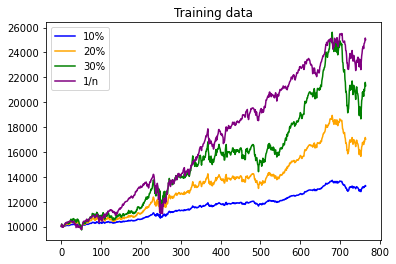

In [35]:
T, n = rtest_data.shape
#define fine function to get
cum_value = lambda r: 10000*np.cumprod(1+r)
# 10% annual return

#Ask for 10% annual return
r1 = rtest_data @ w1 #Portfolio return time series

# 20% annual return
r2 = rtest_data @ w2 #Portfolio return time series

# 40% annual return
r3 = rtest_data @ w3 #Portfolio return time series

# Uniform portolio
#w = (1/n)*np.ones(n)
r4 = rtest_data @ w4 #Portfolio return time series

rTesting = [r1,r2,r3,r4]

for r,c,i in zip(rTesting,['blue','orange','green','purple'],['10%','20%','30%','1/n']):
    plt.plot(np.arange(T), cum_value(r), c, label='%s' % i)


plt.title("Training data")
plt.legend()
plt.show()

Show the annual risk and return for each assest (hollow circles) along with the pareto optimized portfolios (filled circles). 

In [36]:
#Get the return and risk from the portfolios and plot them 
trainingReturnRisk  = [AnnualRiskandReturn(i) for i in rTraining]
testsReturnRisk  = [AnnualRiskandReturn(i) for i in rTesting]

trainResult = pd.DataFrame(np.around(trainingReturnRisk,2))
testResult = pd.DataFrame(np.around(testsReturnRisk,2))

#organize data into train and test with return and risk for each set of data
dd = pd.concat([trainResult,testResult],axis = 1)
dd.columns = pd.RangeIndex(dd.columns.size)
header = [np.array(['Train','Train','Test','Test']), np.array(['Return','Risk','Return','Risk'])] 
df = pd.DataFrame(dd.to_numpy(), columns = header )   
df

Train         Test      
  Return  Risk Return  Risk
0   0.10  0.04   0.09  0.06
1   0.20  0.11   0.19  0.15
2   0.30  0.17   0.28  0.24
3   0.19  0.14   0.32  0.20

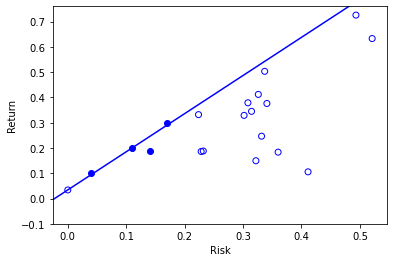

In [37]:
I = np.identity(n)
risk_return = [AnnualRiskandReturn(rtest_data@I[i]) for i in range(n)]
#unpack list of tuples
y, x = zip(*risk_return)

plt.scatter(x, y,facecolors='none', edgecolors='b')
plt.scatter(trainResult[1],trainResult[0],color = 'b')

#create line that show the pareto portfolios at 10%, 20%, 40$ risk
p1 = x[-1],y[-1] #risk free assets
p2 = (trainResult[1][1],trainResult[0][1]) #
plt.axline(p1, p2, color='b');

plt.ylim(bottom=-0.1)
plt.xlabel('Risk');plt.ylabel('Return');

__Conclusion__

In this notebook we looked at portfoilio optimization using a linear algebra approach. Algorthims covered include, Gram Schmidt, QR Factorization and back substition. We saw that a portfolio optimization can suffer when the portfolio is not well balanced. This does make sense and would be analogous to a poorly balanced portfolio. This is, a portfolio which has all assests concentrated in one sector of the market. An example of this in real time are portfolios which are tech heavy (written May 2, 2022). The month of April 2022 was the worst month on record since 2008. What we are currently seeing is a transition from stocks like tech, which are lucrative during economic booms but suffer druing uncertain economic times. A well balanced portfolio should not reproduce the issues we saw with our weights being uniform even with different returns requested. By dropping a few of the heavly shorted stocks we were able to obtain a more useful portfolio.

Overall - the nitty griddy is described here for fun but in reality we could have done this entrie computation in a few lines of code. For example using numpy we will solve for $w$ with a desired annual return of 10% and then show the result is equivalent to what we computed above. 

In [38]:
#information to setup solution for portfolio optimization 
R = data
T, n = data.shape
mu = np.sum(data, axis = 0).T/T
rho = .1/250

#This is b for the set of linear equations described by Ax = b
b = np.hstack([2*rho*T*mu, 1,rho])

#Solution to portfolio optimization and this is A our set of linear equations Ax = b
KKT = np.vstack([np.column_stack([2*data.T @ data, np.ones(n), mu]),
np.hstack([np.ones(n).T, 0 , 0]), np.hstack([mu.T, 0,0])])

Use numpy's least-squares function to solve the problem. This will return vector x which approximately solves the equation Ax = b and is equivalent to what is shown above. 

In [39]:
#compute constrained linear least square this is x = A^-1 b or the solution to our problem
w = np.linalg.lstsq(KKT, b,rcond=None)
#unpack the weights and store it in varaible ww. 
ww = w[0]
ww = ww[:n]

Show the result we computed above is the equivalent to that computed by numpy's linear least constrained function, [np.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html).


In [40]:
np.round(ww,8) == np.round(w1,8)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

## Sources: 
    
1. Boyd, Stephen, and Lieven Vandenberghe. Introduction to Applied Linear Algebra: Vectors, Matrices, and Least Squares. Cambridge: Cambridge University Press, 2018. 

2. Leung, Jessica, and Dmytro Matsypura. Python Language Companion to Introduction to Applied Linear Algebra: Vectors, Matrices, and Least Squares. Draft. Vol. Draft, 2020. 

3. Leung, Jessica, and Dmytro Matsypura. Python Language Companion to Introduction to Applied Linear Algebra: Vectors, Matrices, and Least Squares. Draft. Vol. Draft, 2020. 